In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import expected_gradients
import seaborn as sns
import fiona
import geopandas as gpd
from datetime import datetime

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [2]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
#base = 'mean' #zeros or mean
grad_steps = 200 #Number of steps to take in calculation of EG
year_index = -1 # Sequence to apply EG to
weights_file = f'../../river-dl/results/baseline/{mod}/rep_5/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/{mod}/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15
num_rand=30

river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_trn'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]
segs = gpd.read_file('../../river-dl/data_DRB/DRB_spatial/segs/segs.shp')
seg_ids = river_dl['ids_tst'][-455:][:,0,:].flatten()
x_vars = river_dl['x_vars']
num_vars = len(x_vars)

x_full=torch.from_numpy(river_dl['x_trn']).to(device).float()
x=x_full[455*year_index:]
dates_x = river_dl['times_trn'][455*year_index:][0].flatten()


x.shape, x_full.shape, adj_matrix.shape, device

(torch.Size([455, 60, 7]),
 torch.Size([295750, 60, 7]),
 (455, 455),
 device(type='cuda', index=0))

In [3]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix,device=device)
    model.load_state_dict(torch.load(weights_file, map_location=device))
    base_preds=slice(90,180)

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)
    base_preds=slice(0,15)
    
model.eval()
model.to(device)

gwnet_wrapper(
  (model): gwnet(
    (start_conv): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
    (residual_convs): ModuleList(
      (0): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (5): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (6): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (7): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (8): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
    )
    (skip_convs): ModuleList(
      (0): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))

## Play around with Expected Gradients

CPU times: user 7.99 s, sys: 922 ms, total: 8.92 s
Wall time: 12.3 s


Text(0.5, 1.0, 'Expected gradient values at one segment\nw.r.t. outputs at all space and time')

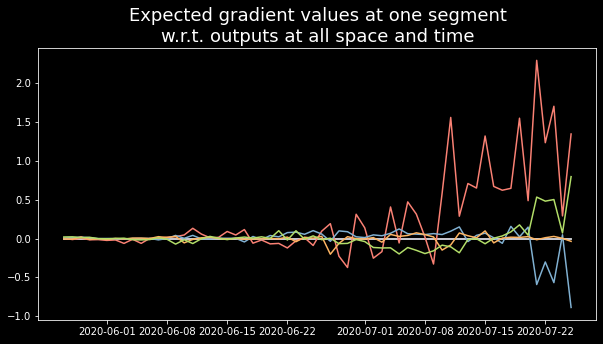

In [4]:
%%time
EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps,temporal_focus=base_preds)
plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, EG_vals[0, :, i])
plt.title('Expected gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

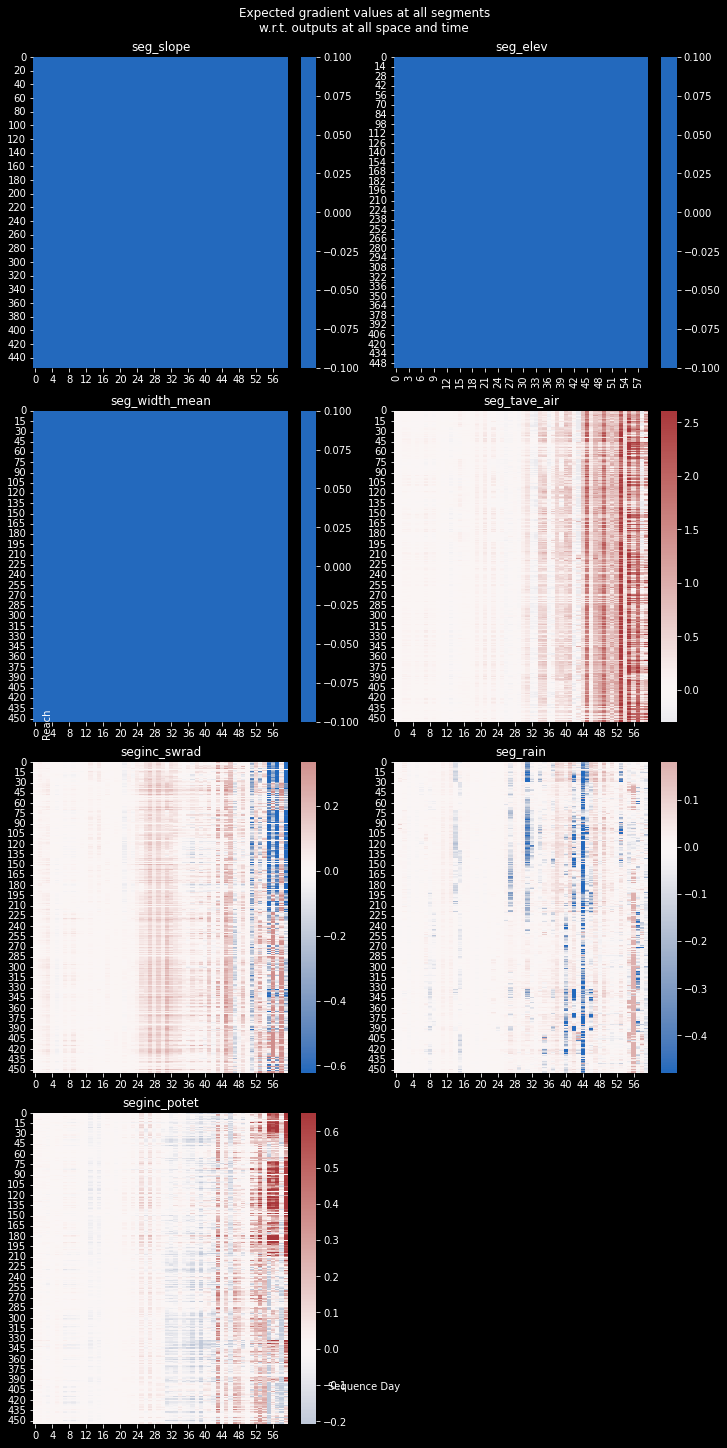

In [5]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20),constrained_layout=True)
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(num_vars):
    EG = EG_vals[:,:,i]
    low_lim = np.quantile(EG,.01)
    high_lim = np.quantile(EG,.99)
    sns.heatmap(EG,vmin=low_lim,vmax=high_lim,center=0, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(x_vars[i])
axes[-1, -1].axis('off')

fig.text(0.5, 0.04, 'Sequence Day', ha='center', va='center')
fig.text(0.06, 0.5, 'Reach', ha='center', va='center', rotation='vertical')
fig.suptitle('Expected gradient values at all segments\nw.r.t. outputs at all space and time')
plt.show()

## lets try to make a seg to seg heatmap

This takes forever and is hard to interpret, so commented out for now

In [6]:
# seg2seg_influence = []
# start = datetime.now()
# for i in range(455):
#     EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, spatial_focus=i, temporal_focus=base_preds)
#     reduced = np.mean(EG_vals,axis=1)
#     seg2seg_influence.append(reduced)
#     if i%30 == 0:
#         print(f"Done: {i}, {datetime.now()-start}")

# seg2seg_influence=np.asarray(seg2seg_influence)

In [7]:
# fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20), constrained_layout=True)

# for i in range(num_vars):
#     EG = seg2seg_influence[:,:,i]
#     low_lim = np.quantile(EG,.01)
#     high_lim = np.quantile(EG,.99)
#     sns.heatmap(EG, vmin=low_lim,vmax=high_lim, center=0,cmap='vlag', ax=axes.reshape(-1)[i])
#     axes.reshape(-1)[i].set_title(x_vars[i])
# axes[-1,-1].axis('off')
# fig.suptitle('Segment to segment Heatmap')

## Pretty hard to interpret, lets try an experiment where we noise everything but the target reach

In [8]:
def noise_segs(seg_of_interest):
    with torch.no_grad():
        y_hat_original = model(x)[:,-pred_length:,:]
    x_hypothesis = torch.rand_like(x)
    x_hypothesis[seg_of_interest] = x[seg_of_interest]
    with torch.no_grad():
        y_hat_hypothesis = model(x_hypothesis)[:,-pred_length:,:]
    y_diff = y_hat_original[seg_of_interest, :].detach().cpu() - y_hat_hypothesis[seg_of_interest, :].detach().cpu()
    y_diff = np.mean(y_diff.numpy())
    return y_diff

In [9]:
batches = river_dl['x_trn'].shape[0]//n_segs
rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')
batches, rand_batch

(650,
 array([577, 371, 192, 345, 253, 382, 602, 218, 178, 521, 270,  52, 506,
        186, 546, 148, 608, 224, 370, 446, 239,  15, 616,  69, 381, 271,
        370, 551, 270, 385]))

In [10]:
diffs =[]
start = datetime.now()
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_trn']).to(device).float()[start_ind:end_ind]
    if i%10 == 0:
         print(f"10 Batch time: {datetime.now()-start}")
    for j in range(n_segs):
        d = noise_segs(j)
        diffs.append(d)

diffs = np.asarray(diffs).reshape(num_rand,n_segs).mean(axis=0)
diffs = diffs*river_dl['y_std'][0]
diffs_sf = pd.DataFrame({'sg_d_nt':seg_ids, 'diffs':np.abs(diffs)}).merge(segs).set_geometry('geometry')
diffs.shape

10 Batch time: 0:01:52.242799
10 Batch time: 0:03:18.534758
10 Batch time: 0:04:44.653194
10 Batch time: 0:05:05.846897


(455,)

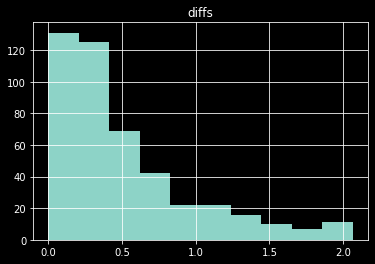

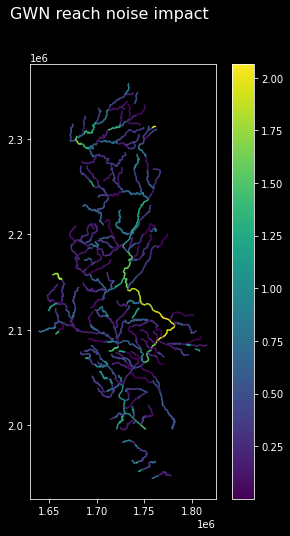

In [11]:
diffs_sf.hist('diffs')
fig, ax = plt.subplots(figsize = (6,8))
diffs_sf.plot(column='diffs', ax = ax, legend = True)
fig.suptitle(f"{mod} reach noise impact",fontsize=16)
plt.savefig(f'../figures/{mod}_30_reach_noise.png',bbox_inches='tight')

## Lets do a similar exercice, but use EGs to look at specific reaches of interest

1638-Contains Neversink; 1639 downstream

1560,1562-Contains Cannonsville; 1566 downstream 

1449-Contains Popocton, 1450 downstream

Random mainstem downstream 1780, 1817 

In [12]:
reach = np.where(seg_ids == 1566)[0][0]

In [13]:
batches = river_dl['x_tst'].shape[0]//n_segs
rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')

egs = []
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
    EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, spatial_focus=reach,temporal_focus=-1)
    EG_vals[reach,:,:] = np.nan
    reduced = np.mean(np.abs(EG_vals),axis=1)
    egs.append(reduced)
egs = np.asarray(egs).mean(axis=0)

(0.0, 1.0, 0.0, 1.0)

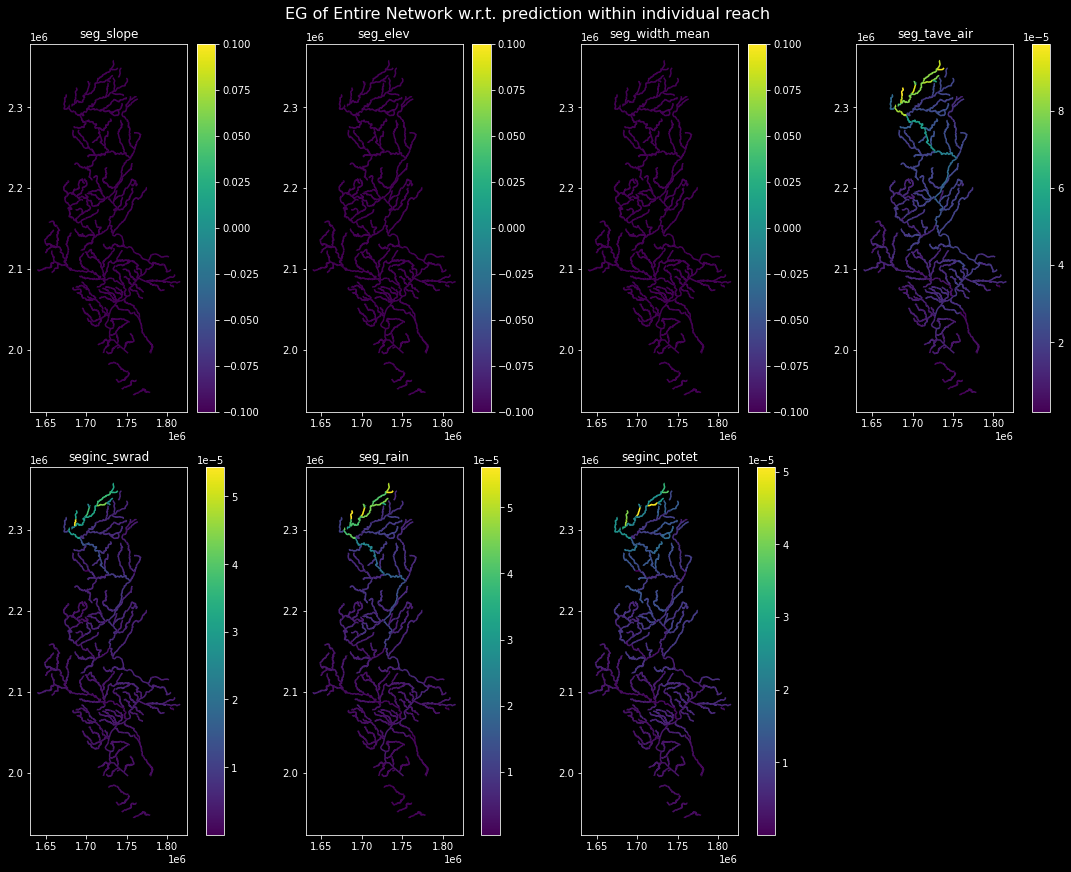

In [14]:
#igs_sf = pd.DataFrame({'sg_d_nt':ids[:len(diffs)], 'igs':reduced}).merge(segs).set_geometry('geometry')
egs_sf = pd.DataFrame(columns=river_dl['x_vars'],data=egs)
egs_sf['sg_d_nt']=seg_ids
egs_sf = egs_sf.merge(segs).set_geometry('geometry')
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(15,12),constrained_layout=True)
fig.suptitle('EG of Entire Network w.r.t. prediction within individual reach',fontsize=16)
for i in range(num_vars):
    egs_sf.plot(column=river_dl['x_vars'][i],ax = axes.reshape(-1)[i],legend=True)
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i]) 
axes[-1,-1].axis('off')

## Lets do some time traveling

In [ ]:
#df = pd.DataFrame(columns=['date','ig_val'])
time_steps = 12
step_interval=15
## Hard to make this applicable to both models because of differences in sequence length
if mod=='RGCN':
    steps_per_seq = seq_len//step_interval
    num_sequences = 1+time_steps//steps_per_seq
    egs = []
    dates=[]
    for i in range(1,num_sequences):
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
        dates_x = river_dl['times_tst'][start_ind:end_ind][0].flatten()
        obs = range(pred_length,seq_len,step_interval)
        for j in obs:
            attributions = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus = j) # attributions for last day in the sequence
            egs.append(np.mean(attributions,axis=0))
            dates.append(dates_x)
        
if mod=='GWN':
    egs = []
    dates = []
    for i in range(1,time_steps):
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
        dates_x = river_dl['times_tst'][start_ind:end_ind][0].flatten()
        EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps, temporal_focus=-1)
        eg_temp_mean = np.mean(EG_vals, axis=0)
        egs.append(eg_temp_mean)
        dates.append(dates_x)

num_plots = len(dates)
fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,2*num_plots), tight_layout=True)
for j in range(num_plots):
    for i in range(num_vars):
        axes[j].plot(dates[j],egs[j][:, i], label = river_dl['x_vars'][i])
    if j == 0:
        axes[j].legend(loc = 'upper left')

## Try to get high level idea of how it works seasonally

In [ ]:
dates = river_dl['times_tst']
months = dates.astype('datetime64[M]').astype(int) % 12 + 1 #d.DatetimeIndex(river_dl['times_tst'])
mask= np.isin(months[:,-1,0],[1,2])
dates_filt = dates[mask]
dates.shape, mask.shape, dates_filt.shape


In [ ]:
num_rand=10
grad_steps = 2
seasons = [[6,7,8],[9,10,11],[12,1,2],[3,4,5]]
egs_months=[]
for m in seasons:
    mask= np.isin(months[:,-1,0],m)
    batches = river_dl['x_tst'][mask].shape[0]//n_segs
    rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')
    egs=[]
    for i in rand_batch:
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst'][mask]).to(device).float()[start_ind:end_ind]
        EG_vals = expected_gradients(x, x_full, adj_matrix, model, n_samples=grad_steps,temporal_focus=-1)
        reduced = np.mean(EG_vals,axis=0) #reduce across segments
        egs.append(reduced)
    egs_mean = np.asarray(egs).mean(axis=0) #reduce across batches
    egs_std = np.asarray(egs).std(axis=0)
    egs_months.append(np.array([egs_mean,egs_std]))


In [ ]:
egs_months[0].shape

In [ ]:
#egs = np.asarray(egs).mean(axis=0)
fig, axes = plt.subplots(nrows=len(egs_months),figsize = (10,12),tight_layout=True)
s=0
e=60
#labs = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']
labs = ['JJA','SON','DJF','MAM']

for i in range(len(egs_months)):
    mean = egs_months[i][0]
    sd = egs_months[i][1]
    [axes[i].plot(range(s,e),mean[s:e,j],label=x_vars[j]) for j in range(num_vars)]
    [axes[i].fill_between(x=range(s,e),y1=mean[s:e,j]+sd[s:e,j],y2=mean[s:e,j]-sd[s:e,j], facecolor='white',alpha=.3) for j in range(num_vars)]
    axes[i].set_title(labs[i])
    #axes[i].set_ylim(-.15,.3)
    if i == 0:
        axes[i].legend(loc = 'upper left')
    #axes[i].set_ylim(0,.4)
#for i in range(num_vars):
#    plt.plot(egs[:, i],label=x_vars[i])
fig.suptitle('Average basin Expected gradient values \nw.r.t. outputs at last time_step',
          fontsize = 18);

In [ ]:
# #egs = np.asarray(egs).mean(axis=0)
fig, axes = plt.subplots(nrows=len(x_vars),figsize = (10,20),constrained_layout=True)
check = np.asarray(egs_months)
labs = ['JJA','SON','DJF','MAM']
for i in range(len(x_vars)):
    [axes[i].plot(range(s,e),check[j,0,s:e,i], label = labs[j]) for j in range(4)]
    axes[i].set_title(x_vars[i])
    axes[i].legend(loc='upper left')

fig.suptitle('Average basin Expected gradient values w.r.t. outputs at last time_step',
          fontsize = 18);

In [ ]:
# fig, axes = plt.subplots(nrows=len(x_vars),figsize = (10,12),tight_layout=True)

# for i in range(len(x_vars)):
#     df = pd.DataFrame(check[:,0,s:e,i].transpose(),columns = labs)
#     df['seq_day']=range(s,e)
#     df.plot(x='seq_day',kind='bar',stacked=True, ax=axes[i], xticks= range(s,e,20))
#     axes[i].set_title(x_vars[i])
# #for i in range(num_vars):
# #    plt.plot(egs[:, i],label=x_vars[i])
# fig.suptitle('Average basin Expected gradient values \nw.r.t. outputs at last time_step',
#           fontsize = 18);

In [ ]:
def compare_temporally_altered(x):
    y_hat_original = model(x)
    # replace first n out of 365 days with random values
    # and see how results change
    noised = []
    for i in range(2,60,3):
        x_hypothesis = x.detach().clone()
        x_hypothesis[:, :-i] = torch.rand_like(x[:,:-i])
        y_hat_hypothesis = model(x_hypothesis)
        diff = torch.abs(y_hat_original[:,-1]-y_hat_hypothesis[:,-1]).squeeze()
        noised.append(diff.detach().cpu().numpy().mean())    
    noised=np.asarray(noised)
    return noised

In [ ]:
batches = river_dl['x_tst'].shape[0]//n_segs
rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')

noised_batches=[]
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
    noised_batches.append(compare_temporally_altered(x))
noised_batches=np.asarray(noised_batches)*river_dl['y_std'][0]
noised_mean = np.mean(noised_batches,axis=0)
noised_sd =np.std(noised_batches,axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel('Days with Real Vals')
ax.set_ylabel('Absolute Change in Pred')
ax.fill_between(range(2,60,3),
                 noised_mean-noised_sd,
                 noised_mean+noised_sd,
                 alpha=.5, color='grey')
ax.plot(range(2,60,3),noised_mean)